In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

1. Load Data

In [20]:
#load data
df = pd.read_csv('C:\\Git\\a3-predicting-car-price-Arun-vEDU\\Cars_a3.csv')

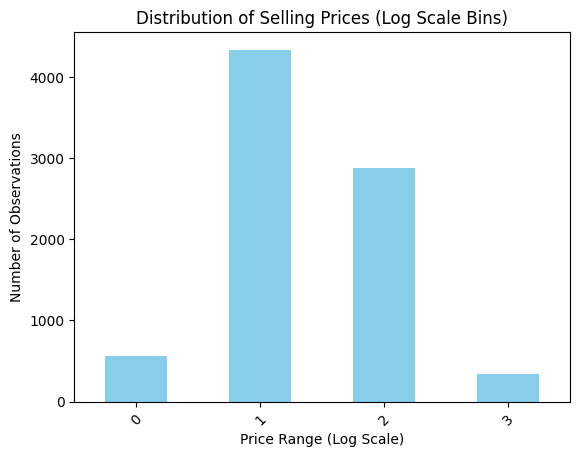

In [22]:
#Step 1: Prepare data
# y is simply the selling price colomn
y = df["selling_price"]

# Covert into log scale
y_log = np.log(df["selling_price"])


binned_data = pd.cut(y_log, bins=4, labels=False)  # Creates 0, 1, 2, 3
# plot the values
# Value counts for each bin
bin_counts = pd.value_counts(binned_data)

# Bar plot
bin_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Selling Prices (Log Scale Bins)')
plt.xlabel('Price Range (Log Scale)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.show()

In [23]:

# Step 2: Add binned_data as a new column in the DataFrame
df['binned_price'] = binned_data

# Step 3: Prepare features and labels
X = df.drop(columns=['selling_price', 'binned_price']) 
y = df['binned_price']  # Original binned labels (0, 1, 2, 3)

print(binned_data)

0       1
1       1
2       1
3       1
4       1
       ..
8123    1
8124    1
8125    1
8126    1
8127    1
Name: selling_price, Length: 8128, dtype: int64


In [24]:
# To check the data types of the columns
print(df.dtypes) 

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
binned_price       int64
dtype: object


In [25]:
# my selected features are 'Max Power' and 'Year' from a1 and a2 assignments.

# Split the 'max_power' column by space
df[['max_power', 'max_power_unit']] = df['max_power'].str.split(' ', expand=True)

# Remove the 'max_power_unit' column
df = df.drop('max_power_unit', axis=1)
df.columns

# Convert 'max_power' to a numeric type
df['max_power'] = pd.to_numeric(df['max_power'])

# To check the data types of the columns
#print(df)
print(df.dtypes)

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power        float64
torque            object
seats            float64
binned_price       int64
dtype: object


In [26]:
# Check the distribution of classes
class_distribution = binned_data.value_counts()

# Display the distribution of each class
print(class_distribution)

selling_price
1    4342
2    2884
0     565
3     337
Name: count, dtype: int64


In [27]:
# X is my selected strong features
# I have selected 2 features "year" and "max_power"
# less features are better.
X = df[        ['year', 'max_power']        ]

In [28]:
#Split the data into train and test
# test set is 20% of our dataset.
# This is a medium size data set, that is why it is selected 80%  traning set and 20% test set 

from sklearn.model_selection import train_test_split

#  X is your feature set and binned_data is your target (with 4 classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#check for null values in traning set,The .isna() method is used to detect missing values (not avalible) and count it
X_train[['year', 'max_power']].isna().sum()


year           0
max_power    167
dtype: int64

In [30]:
#check for null values in test set, and count it
X_test[['year', 'max_power']].isna().sum()

year          0
max_power    49
dtype: int64

In [31]:
# max power has 167 missing values. So we can fill them with ratio, the distribution of the 'max_power' is skewed.
# X_train is  training dataset and 'max_power' contains missing values

# Step 1: Calculate the ratio of each unique value in 'max_power'
ratio = X_train['max_power'].value_counts(normalize=True)

# Step 2: Define a function to sample values based on these ratios
def fill_missing_values(column, value_distribution):
    missing_indices = column[column.isnull()].index  # Find indices where values are missing
    filled_values = np.random.choice(value_distribution.index, 
                                     size=len(missing_indices), 
                                     p=value_distribution.values)  # Sample from distribution
    
    # Fill the missing values with sampled values
    column.loc[missing_indices] = filled_values
    return column

# Step 3: Fill missing values in 'max_power' based on the ratio
X_train['max_power'] = fill_missing_values(X_train['max_power'], ratio)

# Now, X_train['max_power'] has the missing values filled based on the value distribution
print(X_train['max_power'].isnull().sum())  # This should return 0 (no missing values)


0


In [32]:
# Step 4: Fill missing values in 'max_power' in X_test using the same ratio as X_train
X_test['max_power'] = fill_missing_values(X_test['max_power'], ratio)

# Now, X_test['max_power'] should have the missing values filled based on the distribution from X_train
print(X_test['max_power'].isnull().sum())  # This should also return 0 (no missing values)

0


In [33]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Assuming y_train is already in label form (not one-hot encoded)
# No need to use idxmax if it's already a Series with labels
y_labels = y_train  # If y_train is already the labels (0, 1, 2, 3)

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_labels))  # Class distribution before SMOTE

# Now you can check the shapes again
print("Shape of X_train:", X_train.shape)
print("Shape of y_labels:", y_labels.shape)

# Proceed with SMOTE only after confirming the shapes match
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train, y_labels)

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))  # Class distribution after SMOTE


# One-hot encode y_labels_smote
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Check the first few rows of one-hot encoded labels
print(y_labels_smote_one_hot.head())


Before SMOTE: Counter({1: 3443, 2: 2323, 0: 467, 3: 269})
Shape of X_train: (6502, 2)
Shape of y_labels: (6502,)
After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
   class_0  class_1  class_2  class_3
0    False     True    False    False
1    False     True    False    False
2    False     True    False    False
3    False     True    False    False
4    False     True    False    False


After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
   class_0  class_1  class_2  class_3
0    False     True    False    False
1    False     True    False    False
2    False     True    False    False
3    False     True    False    False
4    False     True    False    False
Shape of X_train_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
Shape of X_test_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
Shape of X_train_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
X shape: (13772, 3)
W shape: (3, 4)
Loss at iteration 0: class_0    0.509497
class_1    0.413825
class_2    0.268015
class_3    0.445521
dtype: float64
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (

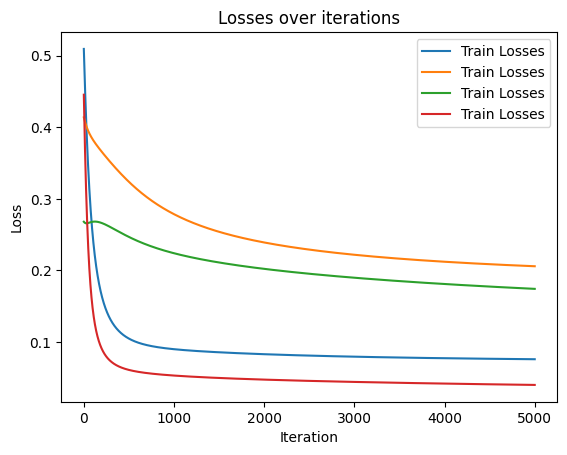

Accuracy: 0.6937
Macro Precision: 0.5954
Macro Recall: 0.8059
Macro F1 Score: 0.6455


In [49]:
# I'm running the custom class for one set of method = batch and one set of parameters to adjest the matrix indexies.
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # If y_train is already the labels (0, 1, 2, 3)
# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train


# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')
print(y_labels_smote_one_hot.head())

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Check shapes
print("Shape of X_train_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)
print("Shape of X_test_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)


import numpy as np
import time
import matplotlib.pyplot as plt

class LogisticRegression:
    
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)   # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
            # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
            #  Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
            
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    #def softmax(self, theta_t_x):
       # return np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True)) / np.sum(np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True)), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        print(f"X shape: {X.shape}")
        print(f"W shape: {W.shape}")
        return self.softmax(X @ W)

    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    def plot(self):
        plt.plot(np.arange(len(self.losses)), self.losses, label="Train Losses")
        plt.title("Losses over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        total = len(y_true)
        return correct / total

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    # New macro precision, recall, and f1 functions
    def macro_precision(self, y_true, y_pred):
        classes = np.unique(y_true)
        precision_scores = [self.precision(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(precision_scores)

    def macro_recall(self, y_true, y_pred):
        classes = np.unique(y_true)
        recall_scores = [self.recall(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(recall_scores)

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)
    
    def weighted_recall(self, class_labels, weights, recalls):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
            weighted_sum += weight * recalls[class_label]  # Multiply recall by weight
        return weighted_sum / sum(weights)

    def weighted_precision(self, class_labels, weights, precisions):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
            weighted_sum += weight * precisions[class_label]  # Multiply precision by weight
        return weighted_sum / sum(weights)
    
    def weighted_f1(self, class_labels, weights, precisions, recalls):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
        
            # Calculate the F1 score for the current class
            if precisions[class_label] + recalls[class_label] > 0:  # Prevent division by zero
                f1_score = 2 * (precisions[class_label] * recalls[class_label]) / (precisions[class_label] + recalls[class_label])
            else:
                f1_score = 0  # Assign 0 if both precision and recall are 0

            weighted_sum += weight * f1_score  # Multiply F1 score by weight
        return weighted_sum / sum(weights)

# Initialize the logistic regression model
model = LogisticRegression(k=4, n=X_train_scaled.shape[1], method='batch', alpha=0.01, max_iter=5000, use_penalty=True, penalty='ridge', lambda_=0.01)

print("Shape of X_train_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)
# Fit the model 
model.fit(X_train_with_intercept, y_labels_smote_one_hot)

# Make predictions on the test set
y_pred = model.predict(X_test_with_intercept)

model.plot()

# Calculate evaluation metrics
accuracy = model.accuracy(y_test, y_pred)
macro_precision = model.macro_precision(y_test, y_pred)
macro_recall = model.macro_recall(y_test, y_pred)
macro_f1 = model.macro_f1(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")


In [59]:
# I'm running the custom class for evaluate bast parameters with out mlflow. 
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # Assuming y_train contains the labels (0, 1, 2, 3)

# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Logistic Regression class
class LogisticRegression:
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)  # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
        # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
        # Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X_test):
            h = self.h_theta(X_test, self.W)  # Get the probabilities
            return np.argmax(h, axis=1)  # Return the predicted class labels directly

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'method': ['batch', 'minibatch', 'sto'],
    'alpha': [0.001, 0.01, 0.1],
    'use_penalty': [False, True],
    'penalty': ['ridge'],
    'lambda_': [0.01, 0.1]
}

# Create a grid of hyperparameters to evaluate
grid = ParameterGrid(param_grid)

best_f1_score = 0
best_params = None

# Step 5: Iterate over all combinations of hyperparameters
for params in grid:
    log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1], **params)
    log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
    
    # Step 6: Make predictions on the test set
    y_test_pred_labels = log_reg.predict(X_test_with_intercept)
   
    
    # Step 7: Evaluate F1 score
    f1 = log_reg.macro_f1(y_test, y_test_pred_labels)
    
    print(f"Params: {params}, F1 Score: {f1}")
    
    # Check for the best F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_params = params

# Output the best hyperparameters and the best F1 score
print("Best F1 Score:", best_f1_score)
print("Best Hyperparameters:", best_params)


After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
Loss at iteration 0: 1.5613249537132738
Loss at iteration 500: 1.1953843884177509
Loss at iteration 1000: 1.0305200842502924
Loss at iteration 1500: 0.9440864768081026
Loss at iteration 2000: 0.8899540726144106
Loss at iteration 2500: 0.851494617428706
Loss at iteration 3000: 0.8218246010328893
Loss at iteration 3500: 0.7976832560477685
Loss at iteration 4000: 0.7773396032478885
Loss at iteration 4500: 0.759782444566727
Time taken: 7.511587619781494
Params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False}, F1 Score: 0.4122783330373547
Loss at iteration 0: 1.2350989506762486
Loss at iteration 500: 1.0388099040971608
Loss at iteration 1000: 0.947439712563527
Loss at iteration 1500: 0.8899040853644551
Loss at iteration 2000: 0.8481365219337291
Loss at iteration 2500: 0.815651527416635
Loss at iteration 3000: 0.7893770765569897
Loss at iteration 3500: 0.767561015425395
Loss at iteration

In [62]:
import os
import mlflow
# Set the environment variables for MLflow authentication
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'

# Set the MLflow tracking URI to the CSIM MLflow server
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th")

# Create an experiment
mlflow.set_experiment("st125159-a3")

<Experiment: artifact_location='mlflow-artifacts:/349075529584389172', creation_time=1728134083048, experiment_id='349075529584389172', last_update_time=1728134083048, lifecycle_stage='active', name='st125159-a3', tags={}>

In [68]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import mlflow  # Import MLflow

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # Assuming y_train contains the labels (0, 1, 2, 3)

# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Logistic Regression class
class LogisticRegression:
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)  # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
        # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
        # Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X_test):
            h = self.h_theta(X_test, self.W)  # Get the probabilities
            return np.argmax(h, axis=1)  # Return the predicted class labels directly

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'method': ['batch', 'minibatch', 'sto'],
    'alpha': [0.001, 0.01, 0.1],
    'use_penalty': [False, True],
    'penalty': ['ridge'],
    'lambda_': [0.01, 0.1]
}

# Create a grid of hyperparameters to evaluate
grid = ParameterGrid(param_grid)

best_f1_score = 0
best_params = None
best_run_details = {}


# End any active run before starting a new one
if mlflow.active_run() is not None:
    mlflow.end_run()

# Start the main MLflow run
with mlflow.start_run() as main_run:
    best_f1_score = -float('inf')  # Initialize the best F1 score
    best_run_details = {}
    
    # Step 5: Iterate over all combinations of hyperparameters
    for params in grid:
        # Use nested runs for each parameter combination
        with mlflow.start_run(run_name=f"Run with params: {params}", nested=True):
            log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1], **params)
            log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
            
            # Step 6: Make predictions on the test set
            y_pred = log_reg.predict(X_test_with_intercept)

            # Calculate F1 score
            f1 = log_reg.macro_f1(y_test, y_pred)  # Use actual test labels
            
            # Log parameters and metrics
            for key, value in params.items():
                mlflow.log_param(key, value)
            
            mlflow.log_metric("f1_score", f1)

            # Update best F1 score and parameters
            if f1 > best_f1_score:
                best_f1_score = f1
                best_params = params
                best_run_details = {
                    'penalty': params['penalty'],
                    'lambda': params['lambda_'],
                    'method': params['method'],
                    'accuracy': f1  # Update this with the appropriate metric if needed
                }

    # Log best F1 score after the main run
    mlflow.log_metric("best_f1_score", best_f1_score)
    print(f"Best F1 Score: {best_f1_score} with parameters: {best_params}")

# Log the best model details in a separate run if necessary
if best_run_details:
    # Start a new run to log the best model details
    if mlflow.active_run() is not None:
        mlflow.end_run()  # Ensure any active run is ended before starting a new one
    with mlflow.start_run(run_name="Best Model Run"):
        # Log the best parameters
        mlflow.log_param("best_penalty", best_run_details['penalty'])
        mlflow.log_param("best_lambda", best_run_details['lambda'])
        mlflow.log_param("best_method", best_run_details['method'])

        # Log the best metrics
        mlflow.log_metric("best_f1_score", best_f1_score)  # Update this with the best F1 score




After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})


2024/10/06 16:53:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-roo-207 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/f5abea3af8f24f069dee10f4e2f03e03.
2024/10/06 16:53:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.230162334765758
Loss at iteration 500: 1.038460635990607
Loss at iteration 1000: 0.9486168455079891
Loss at iteration 1500: 0.8958596293768075
Loss at iteration 2000: 0.8587098726593487
Loss at iteration 2500: 0.8296832428911974
Loss at iteration 3000: 0.805676019480981
Loss at iteration 3500: 0.7851652914657564
Loss at iteration 4000: 0.7672877034326062
Loss at iteration 4500: 0.751493383352824
Time taken: 7.729641437530518


2024/10/06 16:53:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/aa6a65866ed94eacb25b928ef17864ed.
2024/10/06 16:53:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.19341358159653
Loss at iteration 500: 1.4945988884199912
Loss at iteration 1000: 1.1517041156605499
Loss at iteration 1500: 1.000219964960312
Loss at iteration 2000: 0.9223043811330791
Loss at iteration 2500: 0.8736318715662746
Loss at iteration 3000: 0.8387461194284228
Loss at iteration 3500: 0.8114814448236572
Loss at iteration 4000: 0.789002608629995
Loss at iteration 4500: 0.7698363316573134
Time taken: 7.582522869110107


2024/10/06 16:53:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/408279e3e8094899ae4045503a4cd354.
2024/10/06 16:53:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.868412637432961
Loss at iteration 500: 1.3613682126016196
Loss at iteration 1000: 1.0957042997930164
Loss at iteration 1500: 0.9681212255136872
Loss at iteration 2000: 0.8956586173389565
Loss at iteration 2500: 0.8652692271527062
Loss at iteration 3000: 0.8215266439971789
Loss at iteration 3500: 0.7941897705698666
Loss at iteration 4000: 0.7782063392668951
Loss at iteration 4500: 0.7525583888769154
Time taken: 4.11306619644165


2024/10/06 16:53:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/6e03ea94b8be452d9e60838e9bb4d1fa.
2024/10/06 16:53:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6452255457516283
Loss at iteration 500: 1.2409296621371402
Loss at iteration 1000: 1.0480405927890954
Loss at iteration 1500: 0.9521991737405647
Loss at iteration 2000: 0.8991632227515962
Loss at iteration 2500: 0.8553182200572207
Loss at iteration 3000: 0.8249960179137866
Loss at iteration 3500: 0.7966180429268006
Loss at iteration 4000: 0.7780763174624318
Loss at iteration 4500: 0.7633900187941536
Time taken: 4.066738605499268


2024/10/06 16:53:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/5d30b116a1f344b0bf83ef4428d0e3ef.
2024/10/06 16:53:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.1628227166170169
Loss at iteration 500: 1.4079469775892604
Loss at iteration 1000: 0.42090957008312213
Loss at iteration 1500: 0.6083463368586071
Loss at iteration 2000: 1.2705551551618184
Loss at iteration 2500: 0.8045201029189073
Loss at iteration 3000: 1.2502865083079877
Loss at iteration 3500: 0.4625227699926314
Loss at iteration 4000: 1.2993110818422955
Loss at iteration 4500: 1.228174090813012
Time taken: 0.11690950393676758


2024/10/06 16:53:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/758097379c554d7091d021865b2f802c.
2024/10/06 16:53:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 0.7725909156241056
Loss at iteration 500: 1.7534119289491858
Loss at iteration 1000: 0.9373577877116844
Loss at iteration 1500: 0.9486631308162723
Loss at iteration 2000: 0.3680313979577425
Loss at iteration 2500: 0.26250200289743497
Loss at iteration 3000: 0.07558649934922357
Loss at iteration 3500: 0.5229757789958869
Loss at iteration 4000: 0.8026450206153584
Loss at iteration 4500: 0.8977275539062132
Time taken: 0.14921903610229492


2024/10/06 16:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/d12f35acea9449168dc6c218ce4d4aed.
2024/10/06 16:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2647937601941976
Loss at iteration 500: 1.0231745158849028
Loss at iteration 1000: 0.9204663777161042
Loss at iteration 1500: 0.8653733828583887
Loss at iteration 2000: 0.8283675157680127
Loss at iteration 2500: 0.8001447731693601
Loss at iteration 3000: 0.777127434020306
Loss at iteration 3500: 0.7576458289161342
Loss at iteration 4000: 0.7407842042368303
Loss at iteration 4500: 0.725972122530001
Time taken: 7.7965593338012695


2024/10/06 16:53:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/b0f426fe6cd74ea9b257b8dcd6a6a23b.
2024/10/06 16:53:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3393328630884724
Loss at iteration 500: 1.111958377904577
Loss at iteration 1000: 0.9847357790899107
Loss at iteration 1500: 0.9078356038886397
Loss at iteration 2000: 0.8571368768789949
Loss at iteration 2500: 0.8208497883387202
Loss at iteration 3000: 0.7931101891781409
Loss at iteration 3500: 0.7708343681610729
Loss at iteration 4000: 0.7522891890219829
Loss at iteration 4500: 0.7364356986585914
Time taken: 8.069640636444092


2024/10/06 16:53:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/5dd4e10ba3ea46369ec17537b3ba4010.
2024/10/06 16:53:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.406475311102765
Loss at iteration 500: 1.189665107875452
Loss at iteration 1000: 1.0605361104088198
Loss at iteration 1500: 1.004281183133299
Loss at iteration 2000: 0.9419925937260331
Loss at iteration 2500: 0.9017389926148035
Loss at iteration 3000: 0.8569265653438718
Loss at iteration 3500: 0.8307016865130967
Loss at iteration 4000: 0.8057494640099829
Loss at iteration 4500: 0.7870067713053951
Time taken: 4.183231830596924


2024/10/06 16:54:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/a4e4eb4b4d02474d8f7eeb2c238aa294.
2024/10/06 16:54:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.9617626219727364
Loss at iteration 500: 1.3458817595822123
Loss at iteration 1000: 1.081089557326956
Loss at iteration 1500: 0.9525916012166462
Loss at iteration 2000: 0.8800164951138918
Loss at iteration 2500: 0.8571381746512492
Loss at iteration 3000: 0.8110398530893204
Loss at iteration 3500: 0.7890163279742255
Loss at iteration 4000: 0.7628170277558154
Loss at iteration 4500: 0.7426594427808898
Time taken: 4.196523666381836


2024/10/06 16:54:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/573daa55012743108f86f2680ce13c97.
2024/10/06 16:54:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.8977157576232362
Loss at iteration 500: 0.9541033008918643
Loss at iteration 1000: 0.5852316392447302
Loss at iteration 1500: 2.4602120844907556
Loss at iteration 2000: 0.33949567765559263
Loss at iteration 2500: 1.2462005577896278
Loss at iteration 3000: 0.893687470352096
Loss at iteration 3500: 0.23584842101720124
Loss at iteration 4000: 1.0008980585430012
Loss at iteration 4500: 0.03340851797719811
Time taken: 0.11941099166870117


2024/10/06 16:54:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/ece0f1bd4c0c4a48be2c51f5c13ca8a3.
2024/10/06 16:54:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3088119871341566
Loss at iteration 500: 1.015482667748059
Loss at iteration 1000: 1.8028216246608557
Loss at iteration 1500: 0.6232116732275015
Loss at iteration 2000: 1.548975837765112
Loss at iteration 2500: 1.5348654803986546
Loss at iteration 3000: 0.31758511523828215
Loss at iteration 3500: 0.4022268099809826
Loss at iteration 4000: 1.2674060475771867
Loss at iteration 4500: 0.4014676828463146
Time taken: 0.14554047584533691


2024/10/06 16:54:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/475f24fb54ec46efafd53d391e7de3fb.
2024/10/06 16:54:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.49002707622891
Loss at iteration 500: 0.74274628796101
Loss at iteration 1000: 0.6507782869049905
Loss at iteration 1500: 0.6044586412734432
Loss at iteration 2000: 0.574935694800447
Loss at iteration 2500: 0.5537962490431821
Loss at iteration 3000: 0.537594031313873
Loss at iteration 3500: 0.5246227870033603
Loss at iteration 4000: 0.513923131272979
Loss at iteration 4500: 0.5049041026363141
Time taken: 7.944133996963501


2024/10/06 16:54:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/62e7739ea1624cb6867ea3842f42e8c6.
2024/10/06 16:54:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.4506638328549823
Loss at iteration 500: 0.7477095321636298
Loss at iteration 1000: 0.6517448890437858
Loss at iteration 1500: 0.6045401481077483
Loss at iteration 2000: 0.5749031178945674
Loss at iteration 2500: 0.5537905800644886
Loss at iteration 3000: 0.5376276943458401
Loss at iteration 3500: 0.5246848388206939
Loss at iteration 4000: 0.5140019225673725
Loss at iteration 4500: 0.5049913198715724
Time taken: 7.814372301101685


2024/10/06 16:54:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/9e624a801e80488cbae2cfab8124c690.
2024/10/06 16:54:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3148134795954936
Loss at iteration 500: 0.745269994326087
Loss at iteration 1000: 0.6521061573981778
Loss at iteration 1500: 0.5984461507874552
Loss at iteration 2000: 0.5768820574542604
Loss at iteration 2500: 0.5576875804386737
Loss at iteration 3000: 0.5418522278678705
Loss at iteration 3500: 0.5220520943536268
Loss at iteration 4000: 0.504453067873276
Loss at iteration 4500: 0.5076195447879045
Time taken: 4.108449220657349


2024/10/06 16:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/c9bb1b8b56d3485d9851109672f588a3.
2024/10/06 16:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3558263751542288
Loss at iteration 500: 0.7137823902214054
Loss at iteration 1000: 0.6363516291512626
Loss at iteration 1500: 0.5934044032241509
Loss at iteration 2000: 0.5703889380013611
Loss at iteration 2500: 0.5444085054698345
Loss at iteration 3000: 0.5253113332533011
Loss at iteration 3500: 0.506320972921395
Loss at iteration 4000: 0.5051158304006346
Loss at iteration 4500: 0.49479745810933523
Time taken: 4.246465444564819


2024/10/06 16:54:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/8c19ad56552f4d93a0a4b1033b20654c.
2024/10/06 16:54:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.870605725936867
Loss at iteration 500: 0.3148007801806796
Loss at iteration 1000: 0.197142997125672
Loss at iteration 1500: 0.44850329850465104
Loss at iteration 2000: 0.5363830034028313
Loss at iteration 2500: 0.1506320215948881
Loss at iteration 3000: 0.8293731351133173
Loss at iteration 3500: 0.06418388369388404
Loss at iteration 4000: 1.0464935893433833
Loss at iteration 4500: 0.8956271695447436
Time taken: 0.13029217720031738


2024/10/06 16:54:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/d5a8ca29732241f3b130dae788e06233.
2024/10/06 16:54:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.3884541119362703
Loss at iteration 500: 0.8483714009281472
Loss at iteration 1000: 1.224204644124064
Loss at iteration 1500: 0.34694830890314976
Loss at iteration 2000: 0.34224942240462
Loss at iteration 2500: 0.9157243147409363
Loss at iteration 3000: 0.6792483135406553
Loss at iteration 3500: 0.6842310922521754
Loss at iteration 4000: 0.9186020654481775
Loss at iteration 4500: 0.14124631418406483
Time taken: 0.14801383018493652


2024/10/06 16:54:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/1da6c005994241f7970232665e87644e.
2024/10/06 16:54:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5779067669656066
Loss at iteration 500: 0.7494115502275404
Loss at iteration 1000: 0.6506983682725016
Loss at iteration 1500: 0.6032592028131835
Loss at iteration 2000: 0.573757729347213
Loss at iteration 2500: 0.5528335883455895
Loss at iteration 3000: 0.5368396240442036
Loss at iteration 3500: 0.5240348559691683
Loss at iteration 4000: 0.5134619701183067
Loss at iteration 4500: 0.5045385094483448
Time taken: 7.865972995758057


2024/10/06 16:54:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/4b677bd7899d4d86b2c0778442a9be34.
2024/10/06 16:54:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.1979542939091798
Loss at iteration 500: 0.7236030091578233
Loss at iteration 1000: 0.6400487195940077
Loss at iteration 1500: 0.5971832431403314
Loss at iteration 2000: 0.5696357169293342
Loss at iteration 2500: 0.5497657600649561
Loss at iteration 3000: 0.5344366011471711
Loss at iteration 3500: 0.5220948227414373
Loss at iteration 4000: 0.5118653807333077
Loss at iteration 4500: 0.5032075168953605
Time taken: 8.783385038375854


2024/10/06 16:55:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/bcca7066ca024e308dcb8d46a4fc7036.
2024/10/06 16:55:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.4742354986810697
Loss at iteration 500: 0.7180979589927273
Loss at iteration 1000: 0.6354908170303796
Loss at iteration 1500: 0.5899622274991214
Loss at iteration 2000: 0.5650407677412658
Loss at iteration 2500: 0.559177895045993
Loss at iteration 3000: 0.5383219325076368
Loss at iteration 3500: 0.5079602275714832
Loss at iteration 4000: 0.5144711764972584
Loss at iteration 4500: 0.5077781756414698
Time taken: 4.2985618114471436


2024/10/06 16:55:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/016b0ca1e66443fba6d3be4e24823d15.
2024/10/06 16:55:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2186699997786814
Loss at iteration 500: 0.710948589268706
Loss at iteration 1000: 0.6359218744125397
Loss at iteration 1500: 0.5926564932877444
Loss at iteration 2000: 0.5598792011634843
Loss at iteration 2500: 0.5497597508143713
Loss at iteration 3000: 0.5442525600975062
Loss at iteration 3500: 0.522145982206004
Loss at iteration 4000: 0.5096695572523094
Loss at iteration 4500: 0.4860435319343771
Time taken: 4.203206300735474


2024/10/06 16:55:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/8e8ed79abb9b4263a2477b1be24f1227.
2024/10/06 16:55:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 0.6701344212113508
Loss at iteration 500: 1.0946193807260702
Loss at iteration 1000: 0.4679697477769901
Loss at iteration 1500: 1.2278742595882965
Loss at iteration 2000: 0.17751075355146018
Loss at iteration 2500: 0.11730659004001175
Loss at iteration 3000: 0.19585428069958302
Loss at iteration 3500: 5.586777050777313
Loss at iteration 4000: 0.09634752114606612
Loss at iteration 4500: 1.3096791396648548
Time taken: 0.14688968658447266


2024/10/06 16:55:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/661ee8fe200d4d52b1491c7cecd3a1c6.
2024/10/06 16:55:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6851381334245565
Loss at iteration 500: 0.44205710282423744
Loss at iteration 1000: 0.40683830104323804
Loss at iteration 1500: 0.43352026731362203
Loss at iteration 2000: 0.31891081397954557
Loss at iteration 2500: 0.9991626075734867
Loss at iteration 3000: 0.9211419147839566
Loss at iteration 3500: 0.3180117740729057
Loss at iteration 4000: 1.109965431295088
Loss at iteration 4500: 0.2725734854996971
Time taken: 0.15667963027954102


2024/10/06 16:55:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/7148822386084334bc3311db60efb18c.
2024/10/06 16:55:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.4443799832992499
Loss at iteration 500: 0.4958413500362067
Loss at iteration 1000: 0.4543657752152087
Loss at iteration 1500: 0.43702880077673345
Loss at iteration 2000: 0.42767428929829887
Loss at iteration 2500: 0.4218975014754269
Loss at iteration 3000: 0.4180019065588923
Loss at iteration 3500: 0.4152048070720668
Loss at iteration 4000: 0.41310034895766934
Loss at iteration 4500: 0.41145940967423833
Time taken: 9.326090335845947


2024/10/06 16:55:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/615468e8fa5541e38a754b99caf17d15.
2024/10/06 16:55:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.881986582435396
Loss at iteration 500: 0.49567108217952766
Loss at iteration 1000: 0.45428955522926606
Loss at iteration 1500: 0.43700706867269357
Loss at iteration 2000: 0.4276776244580801
Loss at iteration 2500: 0.42191374946472826
Loss at iteration 3000: 0.41802567041624844
Loss at iteration 3500: 0.4152334517904213
Loss at iteration 4000: 0.41313247308850815
Loss at iteration 4500: 0.4114942092007313
Time taken: 8.214168548583984


2024/10/06 16:55:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/fce687b1b7c94519b628472a5fa5d9eb.
2024/10/06 16:55:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.364401097878513
Loss at iteration 500: 0.5011171499467073
Loss at iteration 1000: 0.4564695456528102
Loss at iteration 1500: 0.44999242153007357
Loss at iteration 2000: 0.41512690647243955
Loss at iteration 2500: 0.40888646649075544
Loss at iteration 3000: 0.42015545225152034
Loss at iteration 3500: 0.4194348192034563
Loss at iteration 4000: 0.41911104360082496
Loss at iteration 4500: 0.4094938703043096
Time taken: 4.286442518234253


2024/10/06 16:55:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/4a893cfc95614ae6b28fe13debaa09bc.
2024/10/06 16:55:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6415612158252744
Loss at iteration 500: 0.4964528228243611
Loss at iteration 1000: 0.45596790809507065
Loss at iteration 1500: 0.4343382445697814
Loss at iteration 2000: 0.4341828438066294
Loss at iteration 2500: 0.41535510488094907
Loss at iteration 3000: 0.4091026476938752
Loss at iteration 3500: 0.42196964880954274
Loss at iteration 4000: 0.40991856810987976
Loss at iteration 4500: 0.40748549911827336
Time taken: 4.3009467124938965


2024/10/06 16:55:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/f992347fab0841c8a96811340e2da72f.
2024/10/06 16:55:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.2905995954165155
Loss at iteration 500: 0.5568373769895342
Loss at iteration 1000: 2.8331513687317975
Loss at iteration 1500: 0.23504391635081082
Loss at iteration 2000: 0.3538669278080638
Loss at iteration 2500: 0.00011850283254656527
Loss at iteration 3000: 0.177649986493907
Loss at iteration 3500: 0.29759214788917066
Loss at iteration 4000: 0.000610447638809156
Loss at iteration 4500: 0.13750879815818598
Time taken: 0.12563657760620117


2024/10/06 16:55:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/57adf0739db54e40bb08a6f9d7e9ba70.
2024/10/06 16:55:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.3235042068366445
Loss at iteration 500: 0.3656609418486111
Loss at iteration 1000: 0.1499358920043062
Loss at iteration 1500: 0.551869641417536
Loss at iteration 2000: 0.1693926825037701
Loss at iteration 2500: 1.3261543832091331
Loss at iteration 3000: 0.10564095010594876
Loss at iteration 3500: 0.12205683278307447
Loss at iteration 4000: 0.09969556721962287
Loss at iteration 4500: 0.6792376582634718
Time taken: 0.1397871971130371


2024/10/06 16:55:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/0a5464e56fa14ef487cad802bc247d1d.
2024/10/06 16:55:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3936043487527523
Loss at iteration 500: 0.49614076238105664
Loss at iteration 1000: 0.45449377257693546
Loss at iteration 1500: 0.43708745058253695
Loss at iteration 2000: 0.4277042624618766
Loss at iteration 2500: 0.42191428177054385
Loss at iteration 3000: 0.4180120579735617
Loss at iteration 3500: 0.41521138037430333
Loss at iteration 4000: 0.4131048699797683
Loss at iteration 4500: 0.41146268778446016
Time taken: 8.04539942741394


2024/10/06 16:56:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/ec5e8b49c3e5418eb31ca004909dfe33.
2024/10/06 16:56:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5387754774241302
Loss at iteration 500: 0.49169809811023485
Loss at iteration 1000: 0.4530046330230779
Loss at iteration 1500: 0.43649229653376403
Loss at iteration 2000: 0.42749322045409005
Loss at iteration 2500: 0.4219032125634522
Loss at iteration 3000: 0.4181197144384491
Loss at iteration 3500: 0.41539688838739686
Loss at iteration 4000: 0.4133455734058711
Loss at iteration 4500: 0.41174502426682674
Time taken: 8.034440755844116


2024/10/06 16:56:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/b861461c2e0d441a88a6e714ef568941.
2024/10/06 16:56:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.418012571090361
Loss at iteration 500: 0.49360854719303554
Loss at iteration 1000: 0.45708993923903135
Loss at iteration 1500: 0.43659469213576224
Loss at iteration 2000: 0.43470850077985157
Loss at iteration 2500: 0.42428049997824757
Loss at iteration 3000: 0.41817389494199625
Loss at iteration 3500: 0.4184414703508311
Loss at iteration 4000: 0.39205917102649945
Loss at iteration 4500: 0.41388884319492375
Time taken: 4.181892395019531


2024/10/06 16:56:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/2b7eac5ae9e6452d8d0889289788e2e5.
2024/10/06 16:56:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.7777063921560792
Loss at iteration 500: 0.4929259215808963
Loss at iteration 1000: 0.44670617873364854
Loss at iteration 1500: 0.44569965588887844
Loss at iteration 2000: 0.43152155002076625
Loss at iteration 2500: 0.4338164916439915
Loss at iteration 3000: 0.4040378335966181
Loss at iteration 3500: 0.40593474693835147
Loss at iteration 4000: 0.4123244351483356
Loss at iteration 4500: 0.41598817418458195
Time taken: 4.2165303230285645


2024/10/06 16:56:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/bffb7cc91ca744c5843ef1d3185a96ae.
2024/10/06 16:56:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.7625639370362804
Loss at iteration 500: 0.056456453635188364
Loss at iteration 1000: 0.0002164299998189567
Loss at iteration 1500: 0.33273454371790967
Loss at iteration 2000: 0.20519136003422858
Loss at iteration 2500: 0.5965459528894677
Loss at iteration 3000: 0.011713562352360242
Loss at iteration 3500: 0.24108450590021432
Loss at iteration 4000: 0.03478954990939078
Loss at iteration 4500: 0.08993108538469004
Time taken: 0.11619091033935547


2024/10/06 16:56:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/0a497687aae34f0d8005c952af5c3b44.
2024/10/06 16:56:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 3.1975288897915437
Loss at iteration 500: 0.36809317934538877
Loss at iteration 1000: 0.2372608648363188
Loss at iteration 1500: 0.8324031629369278
Loss at iteration 2000: 1.2407413771797666
Loss at iteration 2500: 0.9533141336805923
Loss at iteration 3000: 1.09530056284878
Loss at iteration 3500: 1.2744236117767136
Loss at iteration 4000: 0.6224521436997392
Loss at iteration 4500: 1.3799232874942078
Time taken: 0.1460893154144287


2024/10/06 16:56:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e80cac444f9f4ac28021ac5fa9779cca.
2024/10/06 16:56:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.
2024/10/06 16:56:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-carp-28 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/2b2708b360fd455ba6ad6bc54d1833cd.


Best F1 Score: 0.6987939073917915 with parameters: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False}


2024/10/06 16:56:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.
2024/10/06 16:56:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Run at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/81828ec0848f4710a9e4e19c41c4a4df.
2024/10/06 16:56:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Based on the experiment the best set of paramenters with resepect to f1 score are
Best F1 Score: 0.6987939073917915 with parameters: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False}

I only use f1 score here as there is no domain knowledge to evaluate recall, precision.

In [69]:
# Find the best model from the logged runs
best_run = None
best_f1_score = -float('inf')

# Fetch all runs from the experiment
runs = mlflow.search_runs(order_by=["metrics.best_f1_score desc"])
if not runs.empty:
    best_run = runs.iloc[0]  # Get the run with the best F1 score
    best_f1_score = best_run["metrics.best_f1_score"]

# Register the best model
if best_run is not None:
    model_uri = f"runs:/{best_run.run_id}/model"  # Use the URI of the logged model
    model_name = "st125159-a3-model"  # Student ID
    
    # Register the model
    mlflow.register_model(model_uri, model_name)
    
    # Transition the model to staging
    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(
        name=model_name,
        version=1,  # This should be the version of the model you just registered
        stage="staging"
    )
else:
    print("No runs found to register a model.")


Successfully registered model 'st125159-a3-model'.
2024/10/06 17:24:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st125159-a3-model, version 1
Created version '1' of model 'st125159-a3-model'.
